In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix
from keras.models import Model
from keras.layers import Input, Dense
from keras import regularizers
from keras.callbacks import ModelCheckpoint, TensorBoard
import tensorflow as tf

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [2]:
df = pd.read_csv('data/creditcard.csv')

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.shape

(284807, 31)

In [5]:
df.shape

(284807, 31)

In [6]:
#checking for missing values
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [7]:
count_class = df.Class.value_counts()   
print(count_class.dtype)

print(f"Fraaud Cases: {count_class[1]} | {count_class[1]/len(df)*100:.4f}%")
print(f"Normal Cases: {count_class[0]} | {count_class[0]/len(df)*100:.4f}%")

int64
Fraaud Cases: 492 | 0.1727%
Normal Cases: 284315 | 99.8273%


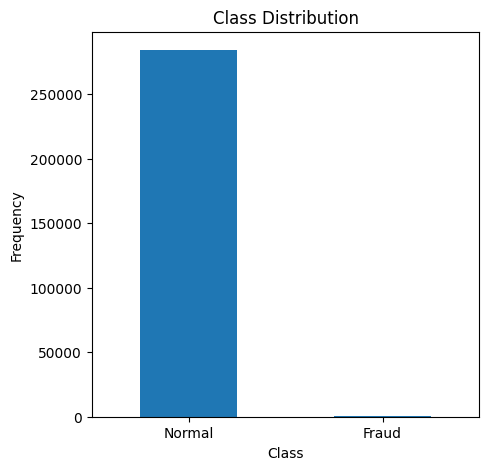

In [8]:
#visualizing the distribution of the classes
plt.figure(figsize=(5,5))

count_class.plot(kind='bar', rot=0 )
plt.title("Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show();

In [9]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

print(frauds.shape)
print(normal.shape)

(492, 31)
(284315, 31)


In [10]:
print(f"fraud_description -> \n{frauds.Amount.describe()}")
print(f"\nnormal_trans_desc -> \n{normal.Amount.describe()}")

fraud_description -> 
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

normal_trans_desc -> 
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64


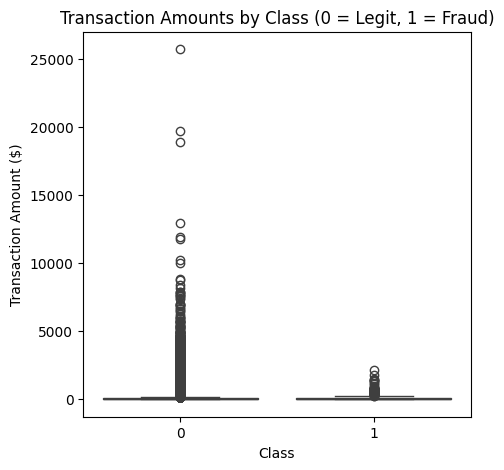

In [11]:
# Create a new DataFrame with Amount and Class
data = df[['Amount', 'Class']]

# Create boxplot grouped by Class (0: Legit, 1: Fraud)
plt.figure(figsize=(5, 5))
sns.boxplot(x='Class', y='Amount', data=data)

# Add labels
plt.title('Transaction Amounts by Class (0 = Legit, 1 = Fraud)')
plt.xlabel('Class')
plt.ylabel('Transaction Amount ($)')

plt.show()


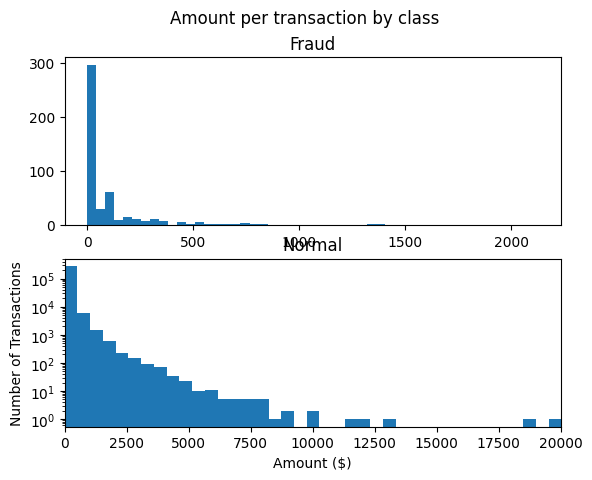

In [12]:
f, (ax1, ax2) = plt.subplots(2, 1)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

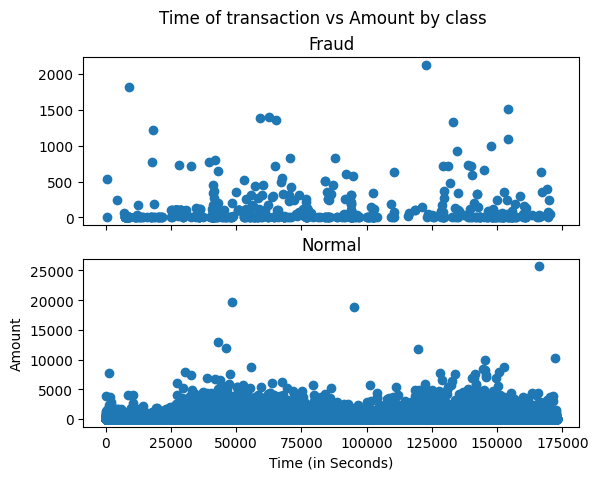

In [13]:
# proofing that time is irrelevant feature

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [14]:
# therefore dropping time feature
df =df.drop('Time',axis =1)

In [15]:
df.head(2)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


In [16]:
df.shape

(284807, 30)

In [17]:
# Scale the 'Amount'
df['Amount'] = StandardScaler().fit_transform(df[['Amount']])

In [18]:
# Separate features and labels
X = df.drop('Class', axis=1)
y = df['Class']

In [19]:
# Split into train (only legitimate) and test (includes both legitimate and fraud)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train[y_train == 0]  # only legitimate data
X_train = X_train.values
X_test = X_test.values
y_test = y_test.values

In [20]:
# Build Autoencoder
input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="tanh",
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 14)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           105 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 29)             │           232 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 813 (3.18 KB)

 Trainable params: 813 (3.18 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Train Autoencoder
nb_epoch = 30
batch_size = 32

history = autoencoder.fit(X_train, X_train,
                          epochs=nb_epoch,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(X_test, X_test),
                          verbose=1)

Epoch 1/30
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.4986 - loss: 0.8731 - val_accuracy: 0.6590 - val_loss: 0.7893
Epoch 2/30
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.6653 - loss: 0.7462 - val_accuracy: 0.6765 - val_loss: 0.7746
Epoch 3/30
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6708 - loss: 0.7407 - val_accuracy: 0.6746 - val_loss: 0.7732
Epoch 4/30
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.6752 - loss: 0.7421 - val_accuracy: 0.6775 - val_loss: 0.7693
Epoch 5/30
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6778 - loss: 0.7286 - val_accuracy: 0.6845 - val_loss: 0.7662
Epoch 6/30
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.6814 - loss: 0.7273 - val_accuracy: 0.6807 - val_loss: 0.7665
Epoch 7/30
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6821 - loss: 0.7393 - val_accuracy: 0.6820 - val_loss: 0.7634
Epoch 8/30
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6809 - loss: 0

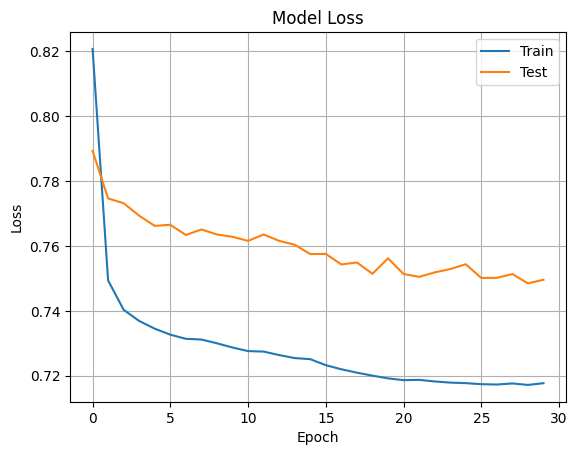

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.grid(True)
plt.show()

In [23]:
X_test_pred = autoencoder.predict(X_test)
reconstruction_error = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [24]:
print(reconstruction_error)

[78.43661348  0.84933616  0.28468825 ...  0.49689277  0.10929622
  1.74025892]


In [25]:
# Precision-Recall and Threshold Optimization
precision, recall, thresholds = precision_recall_curve(y_test, reconstruction_error)
f1_scores = 2 * precision * recall / (precision + recall + 1e-6)

In [26]:
# Get best threshold
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"Best Threshold (F1-Max): {best_threshold:.4f}")

Best Threshold (F1-Max): 57.8861


In [27]:
# Alternative: pick threshold where recall >= 0.75
for idx, r in enumerate(recall):
    if r >= 0.75:
        recall_threshold = thresholds[max(idx - 1, 0)]
        break
print(f"Recall-Optimized Threshold: {recall_threshold:.4f}")

Recall-Optimized Threshold: 0.0476


In [28]:
# Choose threshold (comment/uncomment as needed)
#THRESHOLD = recall_threshold  # to increase recall
THRESHOLD = best_threshold  # to maximize F1

In [29]:
THRESHOLD = best_threshold * 0.95  # Slightly lower to improve recall

In [30]:
# Make Predictions
y_pred = [1 if err > THRESHOLD else 0 for err in reconstruction_error]

In [31]:
# 📊 Step 9: Evaluation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["Legitimate", "Fraud"]))

[[56846    18]
 [   73    25]]
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     56864
       Fraud       0.58      0.26      0.35        98

    accuracy                           1.00     56962
   macro avg       0.79      0.63      0.68     56962
weighted avg       1.00      1.00      1.00     56962



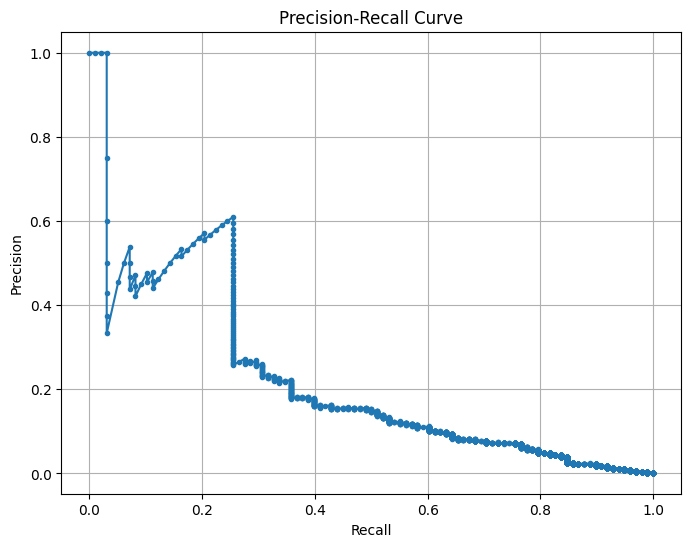

In [32]:
# Step 10: Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

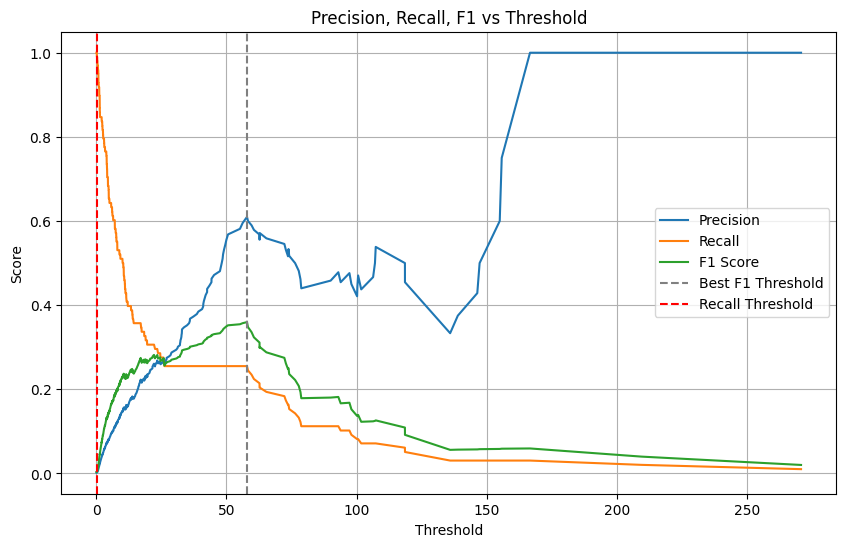

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, f1_scores[:-1], label='F1 Score')
plt.axvline(x=best_threshold, color='gray', linestyle='--', label='Best F1 Threshold')
plt.axvline(x=recall_threshold, color='red', linestyle='--', label='Recall Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, F1 vs Threshold')
plt.legend()
plt.grid(True)
plt.show()
